# 1D Three Phase Simulation of Alloys and PINN model development 


This notebook contains the simulation of 1D Phase change of aluminium alloy. There will be three phases (solid,liquid and mushy).   

The approach used is finite difference method and the physics involved in heat conduction.

Import Libraries

In [43]:
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import csv
from sklearn import svm
import pandas as pd
import itertools

from ht_sim_2 import sim1d



from pyDOE2 import fullfact
from pyDOE2 import fracfact

import statsmodels.api as sm

from statsmodels.formula.api import ols
from scipy.stats import ttest_ind



### <center>Pareto analysis</center>

<p style="font-size:12px; font-family:'Times New Roman', sans-serif; line-height:1.6;">

In this section sensitivity study of the soldification is performed with respect to different material properties and  initial/boundary conditions. The soldification time is the variable under study and it is calcualted based on solution of 1D heat transfer and phase change equation.



Here the parameters/factors are as follows:-

1. Density for material in liquid state $\rho_l$.<br>
2. Density for material in solid state $\rho_s$.<br>
3. Latent Heat of Fusion <br>
4. Specific heat of material in liquid state $C_{pl}$ <br>
5. Specific heat of material in solid state $C_{ps}$ <br>
6. Thermal Conductivity of material in liquid state $k_l$<br>
7. Thermal Conductivity of material in solid state $k_s$ <br>


Boundary conditions:-
8. Surrounding Temperature <br>

Initial Conditions:-

9. Initial_temperature <br>


</p>




The number of runs are large so a fractional factorial design is adopted.

In [44]:
#Create a fractional factorial design

from pyDOE2 import fracfact

num_levels = 2
levels = [0, 1]
num_vars = 10
design2 = fracfact('a b c d e f abcdef abcd bcde adce ')
L_level = 0.99
R_level = 1.01
perc_change = 0.07
factor_levels = {
    'rho_l': [2760.0, 2760.0 * (1 + perc_change)],
    'rho_s': [3000.0, 3000.0 * (1 + perc_change)],
    'k_l': [96.0, 96.0 * (1 + perc_change)],
    'k_s': [110.0,  110.0 * (1 + perc_change)],
    'cp_l': [927.0, 927.0* (1 + perc_change)],
    'cp_s': [967.0, 967.0 * (1 + perc_change)],
    'Surr_temp': [313.0, 313.0 * (1 + perc_change)],
    'L_fusion': [389e3, 389e3 * (1 + perc_change)],
    'temp_init': [880.0, 880.0 * (1 + perc_change)],
    'heat_transfer_coefficient': [10.0, 10.0 * (1 + perc_change)],

}

factor_names = list(factor_levels.keys())

# Create a DataFrame from the fractional factorial design
doe_df_sol_time_fracfact = pd.DataFrame(design2, columns=factor_names)

for factor, levels in factor_levels.items():
    doe_df_sol_time_fracfact[factor] = doe_df_sol_time_fracfact[factor].map({-1: levels[0], 1: levels[1]})

    
print(doe_df_sol_time_fracfact.shape)

(64, 10)


In [45]:
FracFact_doe_sol_time = doe_df_sol_time_fracfact.copy()

FracFact_doe_sol_time['total_sol_time'] = [0.0] * FracFact_doe_sol_time.shape[0] # Data frame inclduing the response variable

# print(Res_doe_sol_time.head(5))



In [46]:
# here the response values are calculated using sim1d function

for i in range(FracFact_doe_sol_time.shape[0]):
    input_values = FracFact_doe_sol_time.iloc[i,:-1].values
    k= sim1d(*input_values)
    FracFact_doe_sol_time.at[i, 'total_sol_time'] = k[0]
    

    

Simulation complete @ time:  24.146944880915306
Simulation complete @ time:  24.39037910339809
Simulation complete @ time:  20.748098025559138
Simulation complete @ time:  25.218438528927486
Simulation complete @ time:  20.679182976478224
Simulation complete @ time:  22.104321684143528
Simulation complete @ time:  25.656705150111144
Simulation complete @ time:  22.7236316443634
Simulation complete @ time:  20.655934832447382
Simulation complete @ time:  22.09374311078781
Simulation complete @ time:  25.74842078110661
Simulation complete @ time:  22.8370957650181
Simulation complete @ time:  22.567238206466183
Simulation complete @ time:  22.794746825609206
Simulation complete @ time:  19.390745818285787
Simulation complete @ time:  23.568634139179558
Simulation complete @ time:  22.743182054821695
Simulation complete @ time:  21.883130182496735
Simulation complete @ time:  25.685177311537007
Simulation complete @ time:  25.076962467343296
Simulation complete @ time:  22.49727641891269


 Histogram of the Total Solidifcation time is plotted

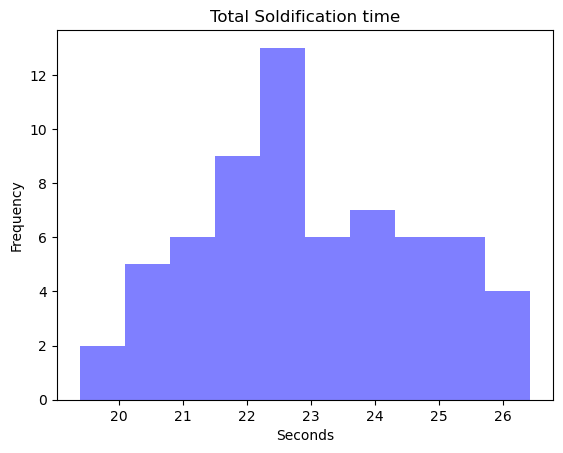

In [47]:
plt.hist(FracFact_doe_sol_time['total_sol_time'], bins=10, alpha=0.5, color='b')
plt.title('Total Soldification time')
plt.xlabel('Seconds')
plt.ylabel('Frequency')
plt.show()

Regression model is developed

In [48]:


# Create the formula for the ANOVA
formula = 'total_sol_time ~ C(rho_l) + C(rho_s) + C(k_l) + C(k_s) + C(cp_l) + C(cp_s) + C(Surr_temp) + C(L_fusion) + C(temp_init)+ C(heat_transfer_coefficient)'

# Fit the model
model = sm.OLS.from_formula(formula, data=FracFact_doe_sol_time).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         total_sol_time   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     1993.
Date:                Mon, 29 Jul 2024   Prob (F-statistic):           1.54e-64
Time:                        11:15:56   Log-Likelihood:                 64.457
No. Observations:                  64   AIC:                            -106.9
Df Residuals:                      53   BIC:                            -83.17
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

The plots of the residuals vs. fitted values are shown below


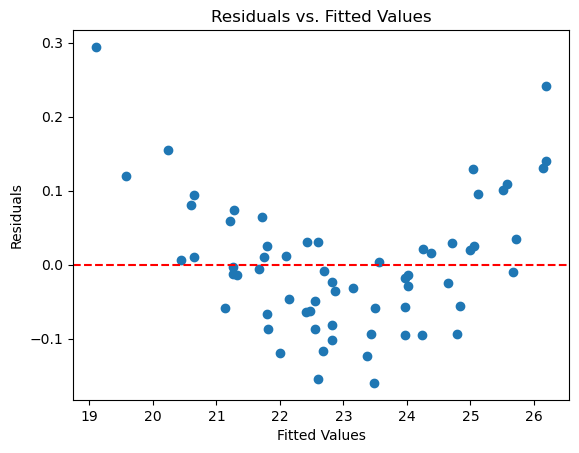

This is followed by the histogram of the residuals


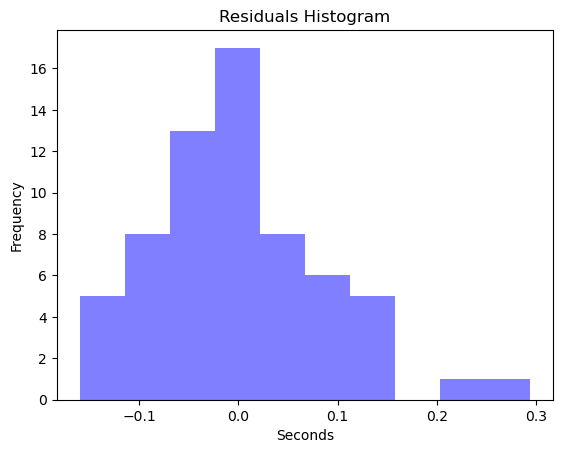

In [49]:
residuals_ols = model.resid
FracFact_doe_sol_time['Residuals'] =residuals_ols
print (f"The plots of the residuals vs. fitted values are shown below")
# Plot residuals vs. fitted values
plt.scatter(model.fittedvalues, residuals_ols)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()


print (f"This is followed by the histogram of the residuals")
plt.hist(residuals_ols, bins=10, alpha=0.5, color='b')
plt.title('Residuals Histogram')
plt.xlabel('Seconds')
plt.ylabel('Frequency')
plt.show()

Residuals of the model was calculated and the normality of its residuals were checked

In [50]:
from scipy.stats import shapiro

# Shapiro-Wilk Test
stat, p_value = shapiro(residuals_ols)
print('Shapiro-Wilk Test Statistic:', stat)
print('p-value:', p_value)

if p_value > 0.05:
    print('The residuals are normally distributed (fail to reject H0).')
else:
    print('The residuals are not normally distributed (reject H0).')


Shapiro-Wilk Test Statistic: 0.9569218461885821
p-value: 0.025412804167099894
The residuals are not normally distributed (reject H0).


Log transformation is performed on the response variable and then new model is developed

In [51]:
transformed_data = np.log( FracFact_doe_sol_time['total_sol_time']+ 1)  # Add 1 to avoid log(0)
LogTrans_doe_sol_time = FracFact_doe_sol_time.copy()
LogTrans_doe_sol_time['transf_data'] = transformed_data

# Create the formula for the ANOVA
formula2 = 'transf_data ~ C(rho_l) + C(rho_s) + C(k_l) + C(k_s) + C(cp_l) + C(cp_s) + C(Surr_temp) + C(L_fusion) + C(temp_init)+ C(heat_transfer_coefficient)'

# Fit the model
model2 = sm.OLS.from_formula(formula2, data=LogTrans_doe_sol_time).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         total_sol_time   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     1993.
Date:                Mon, 29 Jul 2024   Prob (F-statistic):           1.54e-64
Time:                        11:15:57   Log-Likelihood:                 64.457
No. Observations:                  64   AIC:                            -106.9
Df Residuals:                      53   BIC:                            -83.17
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

Residuals of the new model is calcualted and normality tests are performed on the new model

In [52]:
residuals2 = model2.resid

# Shapiro-Wilk Test
stat, p_value = shapiro(residuals2)
print('Shapiro-Wilk Test Statistic:', stat)
print('p-value:', p_value)

if p_value > 0.05:
    print('The residuals are normally distributed (fail to reject H0).')
else:
    print('The residuals are not normally distributed (reject H0).')

Shapiro-Wilk Test Statistic: 0.9709618375405373
p-value: 0.13574171858544942
The residuals are normally distributed (fail to reject H0).


The plots of the residuals vs. fitted values are shown below


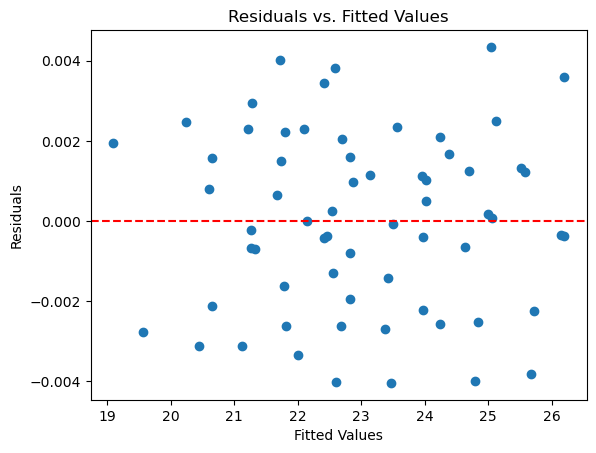

This is followed by the histogram of the residuals


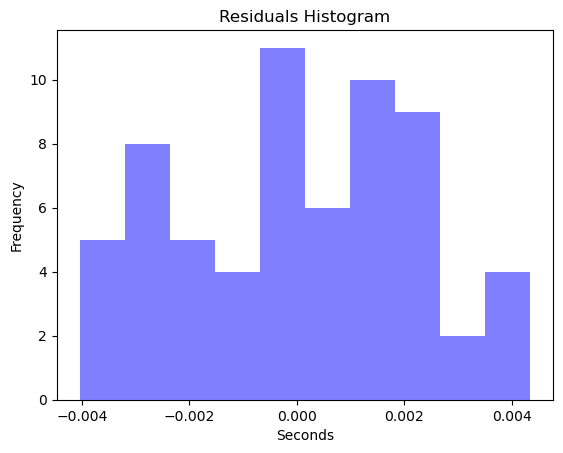

In [53]:
print (f"The plots of the residuals vs. fitted values are shown below")
# Plot residuals vs. fitted values
plt.scatter(model.fittedvalues, residuals2)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()


print (f"This is followed by the histogram of the residuals")
plt.hist(residuals2, bins=10, alpha=0.5, color='b')
plt.title('Residuals Histogram')
plt.xlabel('Seconds')
plt.ylabel('Frequency')
plt.show()


ANOVA Test of the model

In [54]:
from statsmodels.formula.api import ols
# Create the formula for the ANOVA
formula = 'transf_data ~ C(rho_l) + C(rho_s) + C(k_l) + C(k_s) + C(cp_l) + C(cp_s) + C(Surr_temp)+ C(L_fusion) + C(temp_init)+ C(heat_transfer_coefficient)'

# Fit the model
model_anova = ols(formula, data=LogTrans_doe_sol_time).fit()

# Perform ANOVA
anova_results = sm.stats.anova_lm(model_anova, typ=2)

# Display the ANOVA results
print(anova_results)
print(model.summary())

                                sum_sq    df             F        PR(>F)
C(rho_l)                      0.018259   1.0   3098.379496  1.057654e-48
C(rho_s)                      0.015363   1.0   2607.013912  9.459116e-47
C(k_l)                        0.017783   1.0   3017.707965  2.103225e-48
C(k_s)                        0.015865   1.0   2692.142294  4.103680e-47
C(cp_l)                       0.001916   1.0    325.073830  2.862878e-24
C(cp_s)                       0.000503   1.0     85.338221  1.248009e-12
C(Surr_temp)                  0.028283   1.0   4799.321321  1.136839e-53
C(L_fusion)                   0.037272   1.0   6324.772246  8.111132e-57
C(temp_init)                  0.129682   1.0  22005.937806  4.232293e-71
C(heat_transfer_coefficient)  0.061334   1.0  10407.843789  1.635344e-62
Residual                      0.000312  53.0           NaN           NaN
                            OLS Regression Results                            
Dep. Variable:         total_sol_time   R-squ

Here we can observe that the main effects are Thermal conductivity of 

Critical F-value: 4.02301699773367


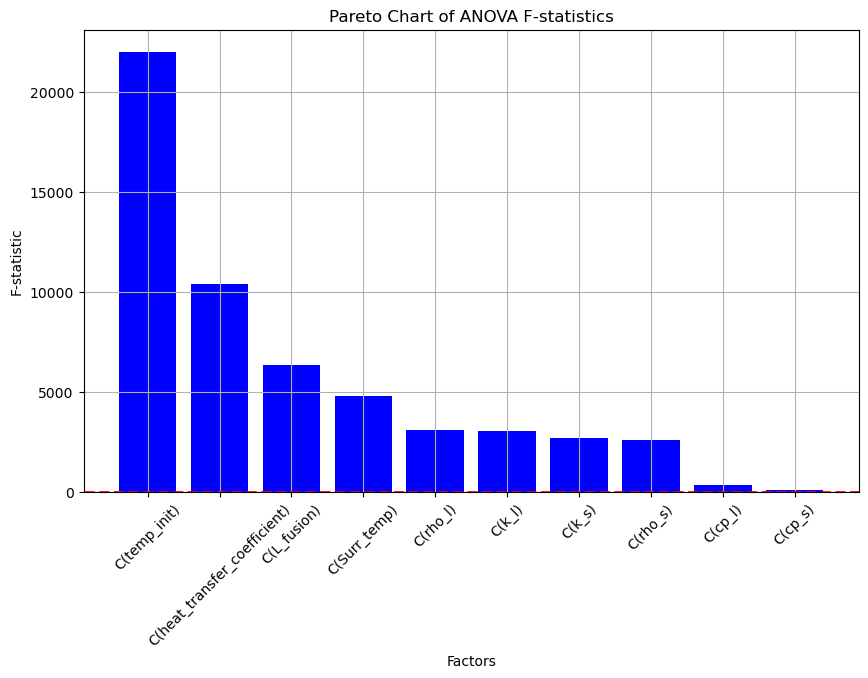

In [55]:
from scipy.stats import f
# Create a DataFrame from the ANOVA results
anova_results_df = anova_results.reset_index()

# Sort by the F-statistic or sum of squares for visualization
anova_results_df = anova_results_df.sort_values(by='F', ascending=False)

dfn = anova_results_df['df'][0]
dfd = model.df_resid

alpha = 0.05
f_critical = f.ppf(1-alpha, dfn, dfd)
print(f'Critical F-value: {f_critical}')

# Plot the Pareto chart
plt.figure(figsize=(10, 6))
plt.bar(anova_results_df['index'], anova_results_df['F'], color='b')
plt.axhline(f_critical, color='r', linestyle='--',linewidth=2)
plt.xlabel('Factors')
plt.ylabel('F-statistic')
plt.title('Pareto Chart of ANOVA F-statistics')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Checking for Multicollinearity

In [56]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming 'data' is your DataFrame
X =LogTrans_doe_sol_time[['rho_l', 'rho_s', 'k_l', 'k_s', 'Surr_temp', 'L_fusion', 'temp_init','cp_l','cp_s']]
y =LogTrans_doe_sol_time['total_sol_time']

# Add constant term
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()
print(model.summary())

# Check VIF
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)


                            OLS Regression Results                            
Dep. Variable:         total_sol_time   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     25.53
Date:                Mon, 29 Jul 2024   Prob (F-statistic):           2.01e-16
Time:                        11:16:00   Log-Likelihood:                -72.295
No. Observations:                  64   AIC:                             164.6
Df Residuals:                      54   BIC:                             186.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -46.8546      9.040     -5.183      0.0

Main effects and Interactions Terms Analysis

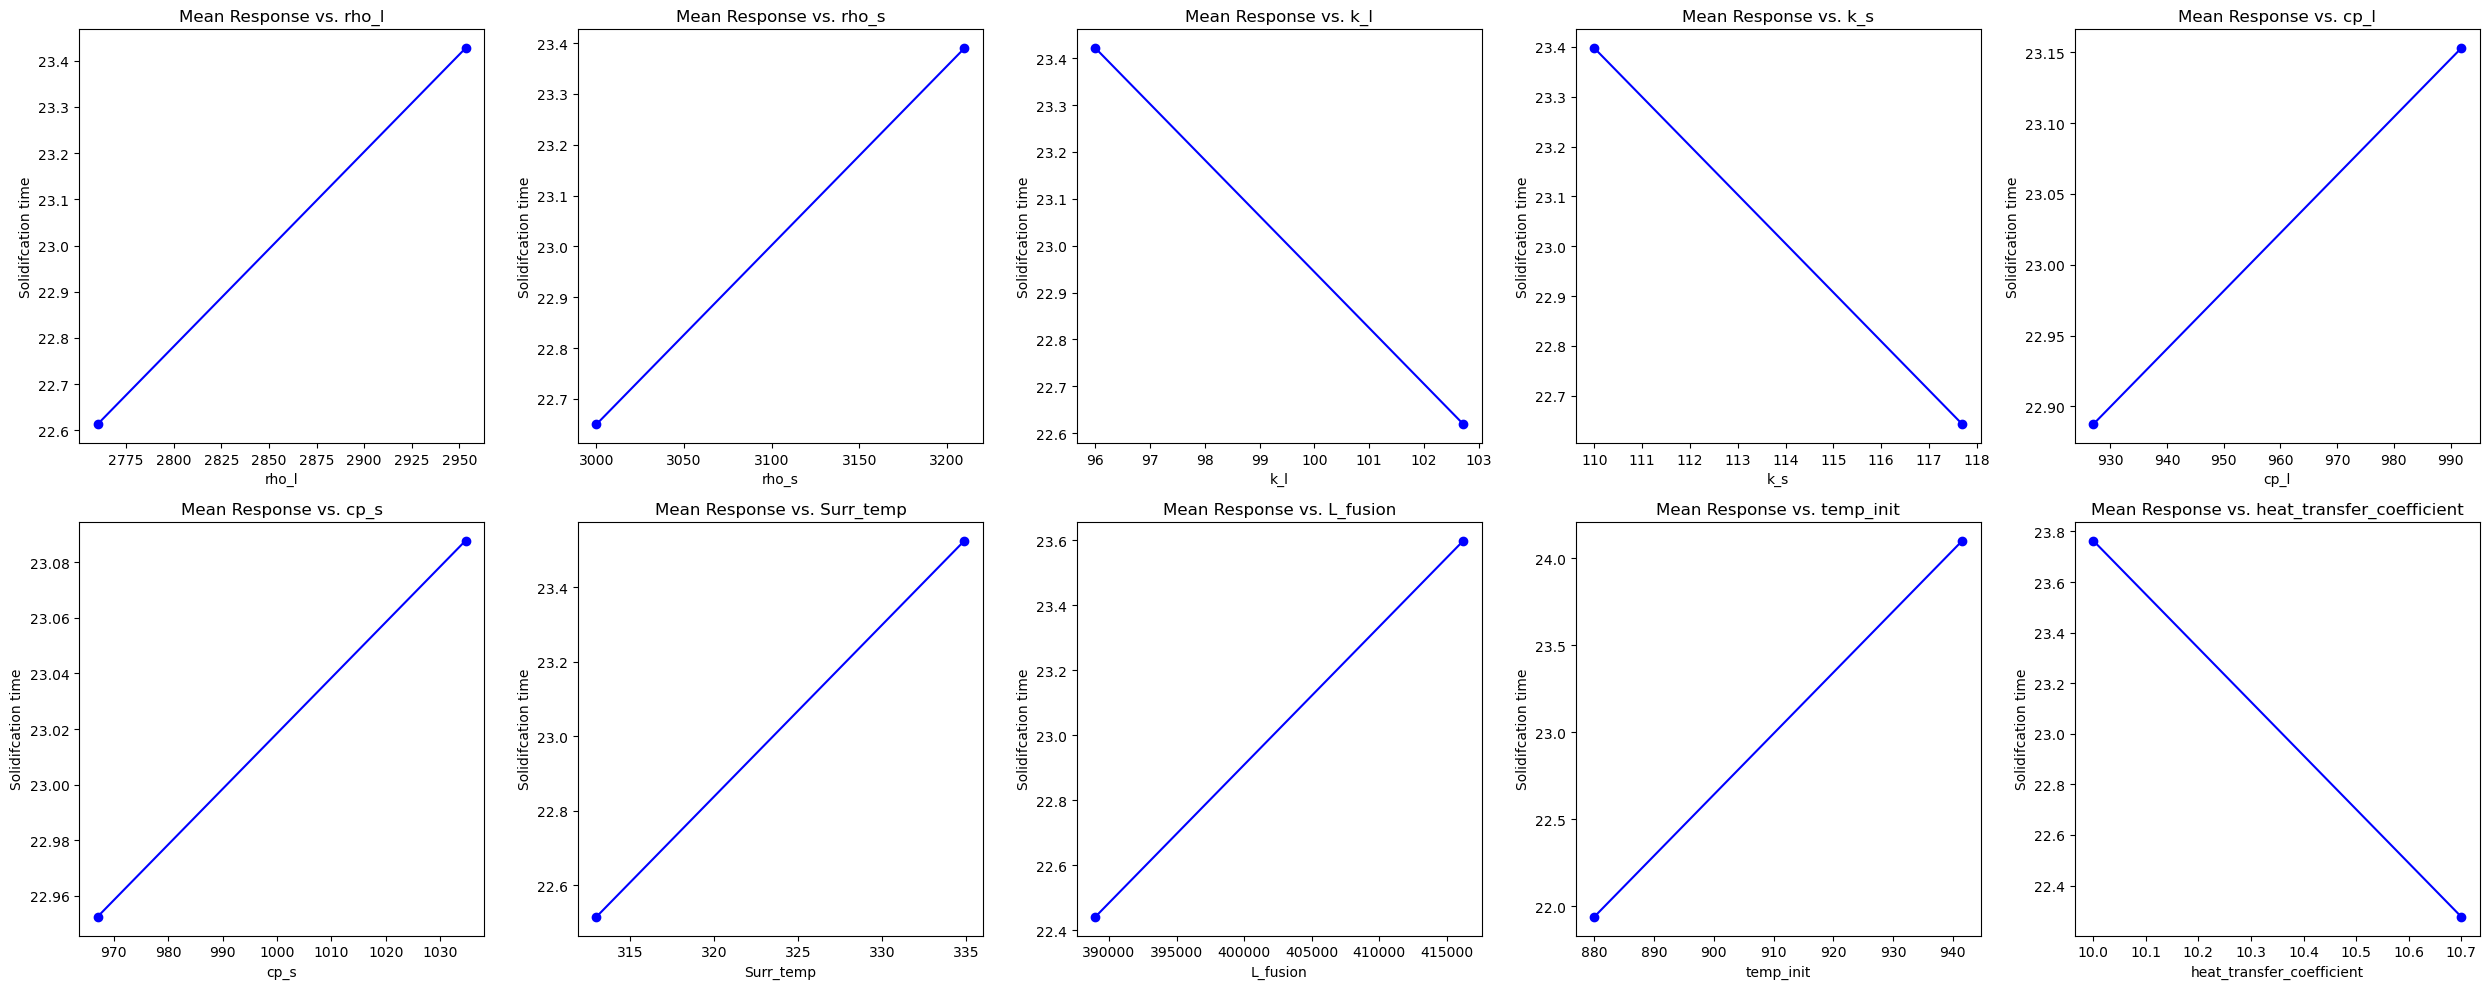

In [57]:
mean_response = {}

for factor in factor_names:
    mean_response[factor] = FracFact_doe_sol_time.groupby(factor)['total_sol_time'].mean()

plt.figure(figsize=(25, 10))

for i, factor in enumerate(factor_names):
    plt.subplot(2, 5, i+1)
    plt.plot(mean_response[factor], marker='o', color='b')
    plt.title(f'Mean Response vs. {factor}')
    plt.xlabel(factor)
    plt.ylabel('Solidifcation time')

plt.tight_layout()
plt.show()


In [58]:
# # Function to plot interaction effects
# def plot_interaction(df, factor1, factor2, response):
#     levels1 = sorted(df[factor1].unique())
#     levels2 = sorted(df[factor2].unique())
    
#     mean_responses = df.groupby([factor1, factor2])[response].mean().unstack()
    
#     plt.figure()
#     for level2 in levels2:
        
#         plt.plot(levels1, mean_responses[level2], marker='o', label=f'{factor2}={level2}')
#     plt.xlabel(factor1)
#     plt.ylabel(f'Mean {response}')
#     plt.title(f'Interaction Effect of {factor1} and {factor2}')
#     plt.legend()
#     plt.show()

# # Plot interaction effects for each pair of factors
# plt.figure(figsize=(10, 6))

# for i in range(len(factor_names)):
    
#     for j in range(i+1, len(factor_names)):
        
#         plot_interaction(FracFact_doe_sol_time, factor_names[i], factor_names[j], 'total_sol_time')
# plt.tight_layout()
# plt.show()

The interaction was observed among rho_l and cp_s , rho_s and cp_s , cp_l and cp_s  & cp_s and temp_init.

In [59]:
formula3 = 'total_sol_time ~ C(rho_l) + C(rho_s) + C(k_l) + C(k_s) + C(cp_l) + C(cp_s) + C(Surr_temp) + C(L_fusion) + C(temp_init) + C(rho_l)*C(cp_s)+ C(rho_s)*C(cp_s) + C(L_fusion)*C(cp_s)+C(cp_l)*C(cp_s)+C(cp_s)*C(temp_init) + C(cp_s)*C(Surr_temp) + C(cp_s)*C(k_s) + C(cp_s)*C(k_l) + C(cp_s)*C(rho_s) + C(cp_s)*C(rho_l) + C(cp_s)*C(L_fusion) + C(cp_s)*C(Surr_temp) + C(cp_s)*C(temp_init) + C(cp_s)*C(heat_transfer_coefficient)'

model4 = sm.OLS.from_formula(formula3, data=LogTrans_doe_sol_time).fit()
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:         total_sol_time   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     1102.
Date:                Mon, 29 Jul 2024   Prob (F-statistic):           1.27e-52
Time:                        11:16:03   Log-Likelihood:                 71.978
No. Observations:                  64   AIC:                            -104.0
Df Residuals:                      44   BIC:                            -60.78
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [60]:
num_center_points = 1

center_point = {factor: np.mean(levels) for factor,levels in factor_levels.items()}

center_pt_df = pd.DataFrame([center_point] * num_center_points, columns=factor_names)

doe_center_pt = pd.concat([doe_df_sol_time_fracfact, center_pt_df], ignore_index=True)
print(doe_center_pt.shape)

(65, 10)


In [61]:
Fractional_Factorial_doe_center_pt = doe_center_pt.copy()

Fractional_Factorial_doe_center_pt['total_sol_time'] = [0.0] * Fractional_Factorial_doe_center_pt.shape[0]


In [62]:
for i in range(Fractional_Factorial_doe_center_pt.shape[0]):
    input_values = Fractional_Factorial_doe_center_pt.iloc[i,:-1].values
    k= sim1d(*input_values)
    Fractional_Factorial_doe_center_pt.at[i, 'total_sol_time'] = k[0]

Simulation complete @ time:  24.146944880915306
Simulation complete @ time:  24.39037910339809
Simulation complete @ time:  20.748098025559138
Simulation complete @ time:  25.218438528927486
Simulation complete @ time:  20.679182976478224
Simulation complete @ time:  22.104321684143528
Simulation complete @ time:  25.656705150111144
Simulation complete @ time:  22.7236316443634
Simulation complete @ time:  20.655934832447382
Simulation complete @ time:  22.09374311078781
Simulation complete @ time:  25.74842078110661
Simulation complete @ time:  22.8370957650181
Simulation complete @ time:  22.567238206466183
Simulation complete @ time:  22.794746825609206
Simulation complete @ time:  19.390745818285787
Simulation complete @ time:  23.568634139179558
Simulation complete @ time:  22.743182054821695
Simulation complete @ time:  21.883130182496735
Simulation complete @ time:  25.685177311537007
Simulation complete @ time:  25.076962467343296
Simulation complete @ time:  22.49727641891269


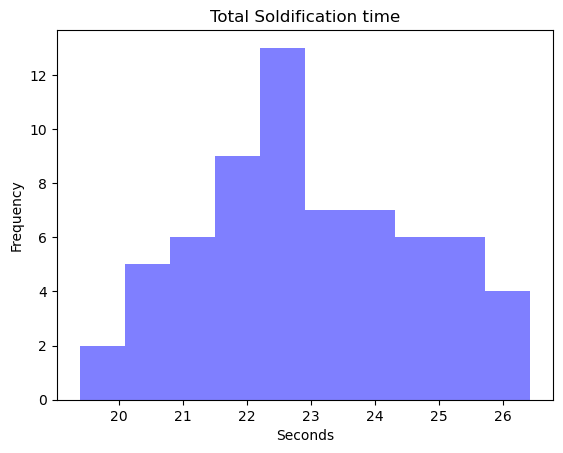

In [63]:
plt.hist(Fractional_Factorial_doe_center_pt['total_sol_time'], bins=10, alpha=0.5, color='b')
plt.title('Total Soldification time')
plt.xlabel('Seconds')
plt.ylabel('Frequency')
plt.show()

In [64]:
formula5 = 'total_sol_time ~ C(rho_l) + C(rho_s) + C(k_l) + C(k_s) + C(cp_l) + C(cp_s) + C(Surr_temp) + C(L_fusion) + C(temp_init)+ C(heat_transfer_coefficient)'

model5 = sm.OLS.from_formula(formula5, data=Fractional_Factorial_doe_center_pt).fit()
print(model5.summary())

                            OLS Regression Results                            
Dep. Variable:         total_sol_time   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     1812.
Date:                Mon, 29 Jul 2024   Prob (F-statistic):           3.93e-64
Time:                        11:18:09   Log-Likelihood:                 65.968
No. Observations:                  65   AIC:                            -107.9
Df Residuals:                      53   BIC:                            -81.84
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

The plots of the residuals vs. fitted values are shown below


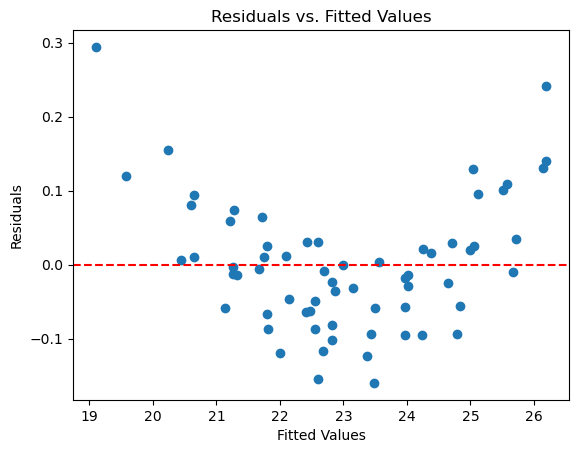

In [65]:
residual5 = model5.resid
Fractional_Factorial_doe_center_pt['Residuals'] =residual5
print (f"The plots of the residuals vs. fitted values are shown below")
# Plot residuals vs. fitted values
plt.scatter(model5.fittedvalues, residual5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()



In [66]:
from scipy.stats import shapiro

# Shapiro-Wilk Test
stat, p_value = shapiro(residual5)
print('Shapiro-Wilk Test Statistic:', stat)
print('p-value:', p_value)

if p_value > 0.05:
    print('The residuals are normally distributed (fail to reject H0).')
else:
    print('The residuals are not normally distributed (reject H0).')
    

Shapiro-Wilk Test Statistic: 0.956368367763833
p-value: 0.02224759980702841
The residuals are not normally distributed (reject H0).


In [67]:
transf_center = np.log( Fractional_Factorial_doe_center_pt['total_sol_time']+ 1)  # Add 1 to avoid log(0)
LogTrans_center = Fractional_Factorial_doe_center_pt.copy()
LogTrans_center['transf_data'] = transf_center

formula6 = 'transf_data ~ C(rho_l) + C(rho_s) + C(k_l) + C(k_s) + C(cp_l) + C(cp_s) + C(Surr_temp) + C(L_fusion) + C(temp_init)+ C(heat_transfer_coefficient)'
model6 = sm.OLS.from_formula(formula6, data=LogTrans_center).fit()
print(model6.summary())


                            OLS Regression Results                            
Dep. Variable:            transf_data   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     5033.
Date:                Mon, 29 Jul 2024   Prob (F-statistic):           7.28e-76
Time:                        11:18:11   Log-Likelihood:                 305.76
No. Observations:                  65   AIC:                            -587.5
Df Residuals:                      53   BIC:                            -561.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [68]:
residuls6 = model6.resid

# Shapiro-Wilk Test
stat, p_value = shapiro(residuls6)
print('Shapiro-Wilk Test Statistic:', stat)
print('p-value:', p_value)

if p_value > 0.05:
    print('The residuals are normally distributed (fail to reject H0).')
else:
    print('The residuals are not normally distributed (reject H0).')
    

Shapiro-Wilk Test Statistic: 0.9723213834977673
p-value: 0.1529506348639053
The residuals are normally distributed (fail to reject H0).


The plots of the residuals vs. fitted values are shown below


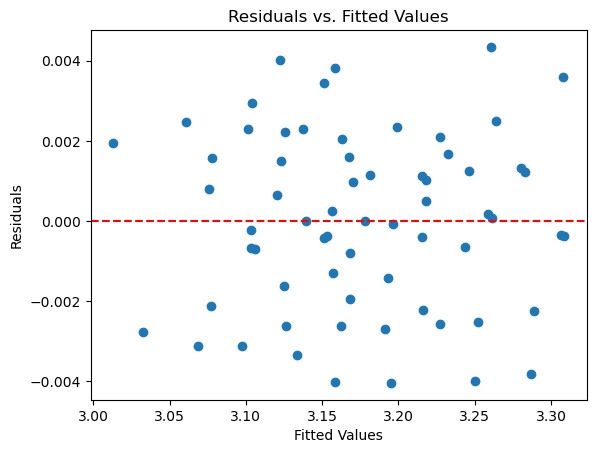

In [69]:
print (f"The plots of the residuals vs. fitted values are shown below")
# Plot residuals vs. fitted values
plt.scatter(model6.fittedvalues, residuls6)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

In [70]:
from statsmodels.formula.api import ols

formula7 = 'transf_data ~ C(rho_l) + C(rho_s) + C(k_l) + C(k_s) + C(cp_l) + C(cp_s) + C(Surr_temp) + C(L_fusion) + C(temp_init)+ C(heat_transfer_coefficient)'

model7 = ols(formula7, data=LogTrans_center).fit()

anova_results7 = sm.stats.anova_lm(model7, typ=2)

print(anova_results7)

                                sum_sq    df             F        PR(>F)
C(rho_l)                      0.020597   2.0   1747.530612  4.154763e-49
C(rho_s)                      0.017828   2.0   1512.651022  1.790865e-47
C(k_l)                        0.024113   2.0   2045.904558  6.752124e-51
C(k_s)                        0.022059   2.0   1871.572817  6.929863e-50
C(cp_l)                       0.005393   2.0    457.579069  3.679032e-34
C(cp_s)                       0.004279   2.0    363.060629  1.163527e-31
C(Surr_temp)                  0.030264   2.0   2567.733386  1.757017e-53
C(L_fusion)                   0.039004   2.0   3309.320150  2.244637e-56
C(temp_init)                  0.130174   2.0  11044.765535  3.505808e-70
C(heat_transfer_coefficient)  0.069954   2.0   5935.339257  4.660566e-63
Residual                      0.000312  53.0           NaN           NaN


In [71]:
if anova_results7['PR(>F)'][0] < 0.05:
    print('The main effects are significant.')
else:
    print('The main effects are not significant.')

The main effects are significant.


/tmp/ipykernel_164864/3305709261.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_results7['PR(>F)'][0] < 0.05:


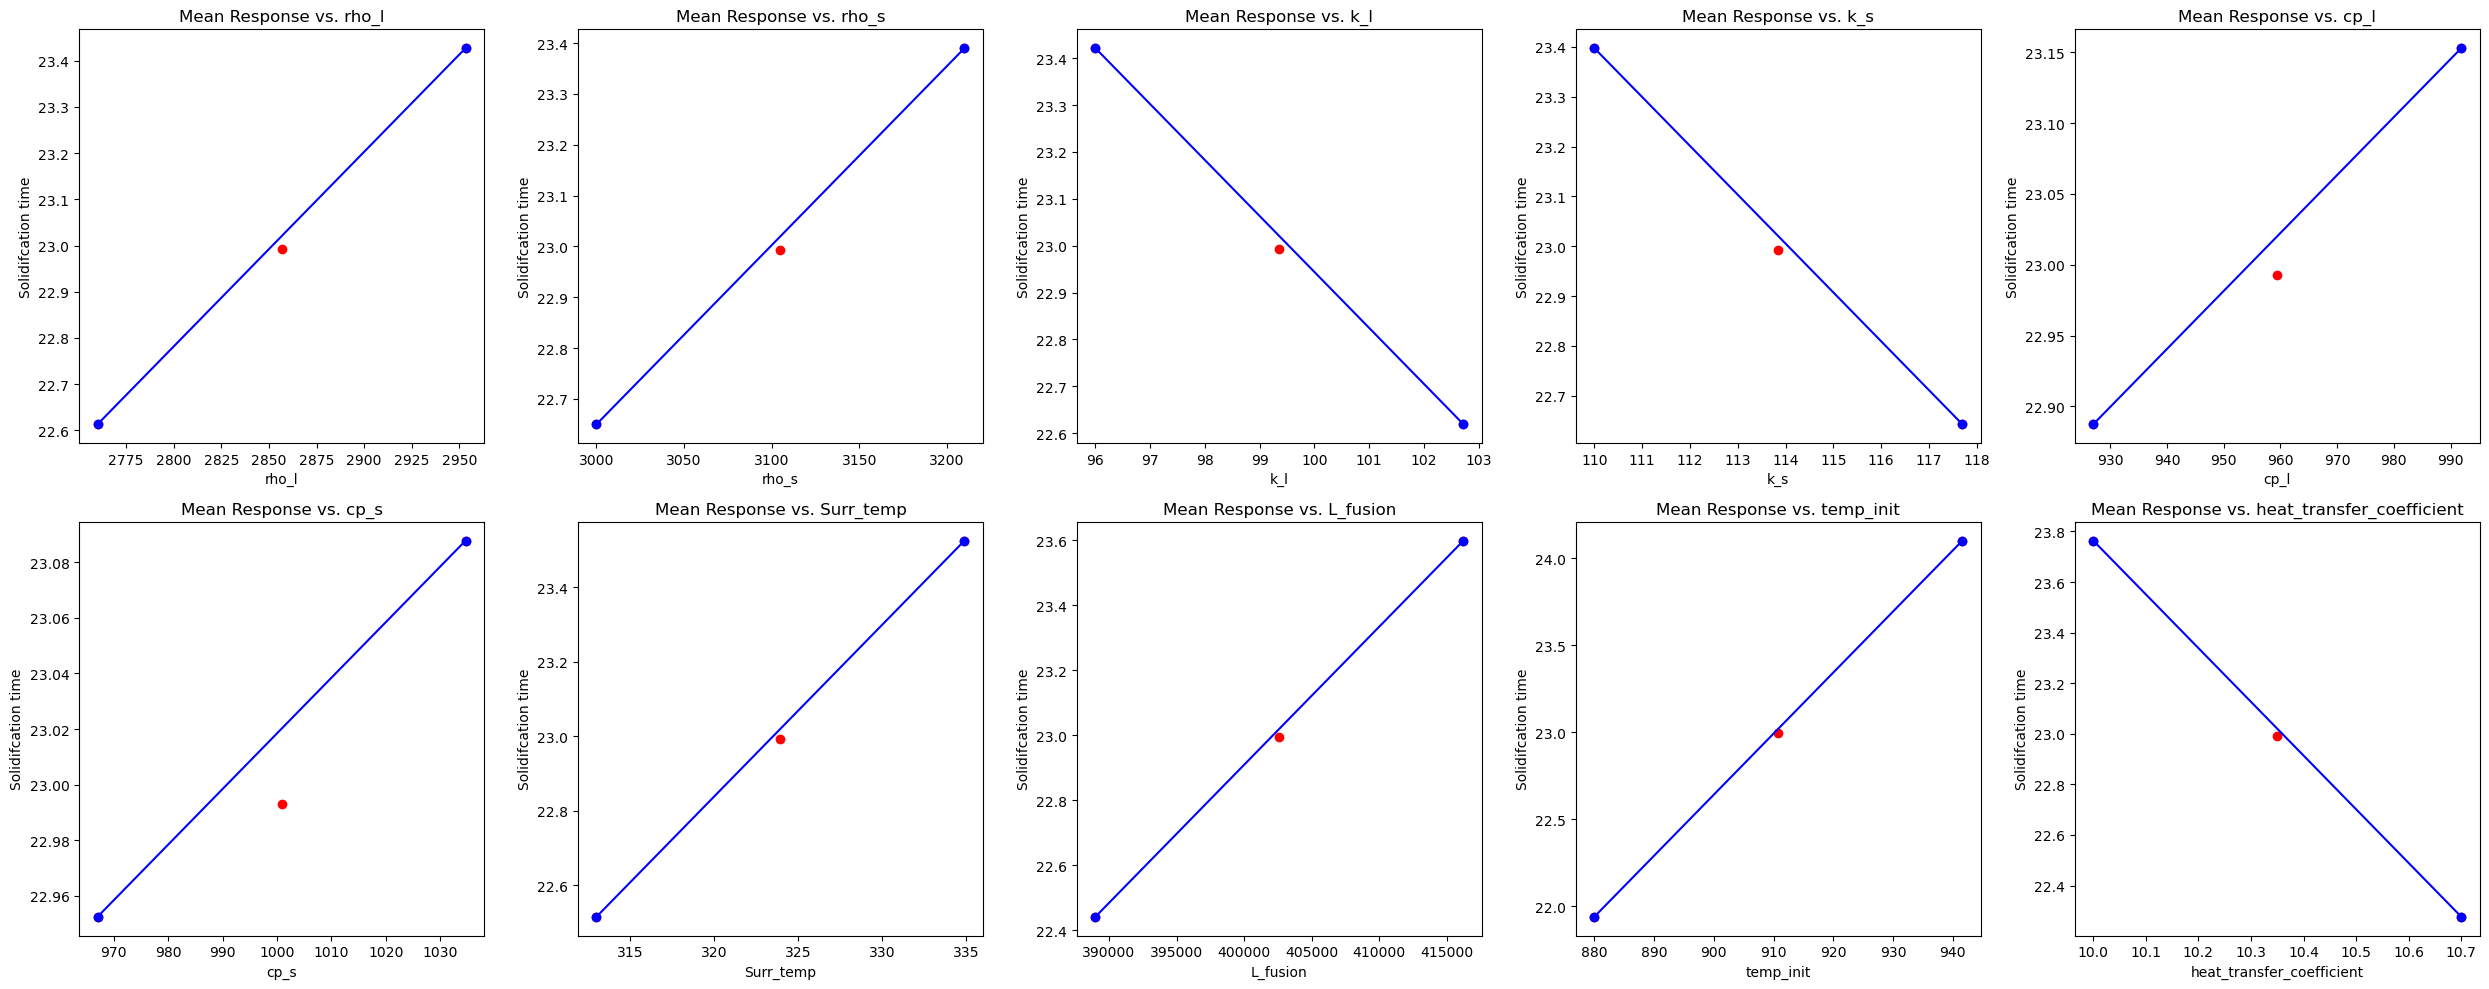

In [72]:
mean_response_center = {}

for factor in factor_names:
    mean_response_center[factor] = Fractional_Factorial_doe_center_pt.groupby(factor)['total_sol_time'].mean()

plt.figure(figsize=(25, 10))

for i, factor in enumerate(factor_names):
    plt.subplot(2, 5, i+1)
    plt.plot(mean_response[factor], marker='o', color='b')
    
    # Plotting the center points
    center_points = mean_response_center[factor]
    plt.scatter(center_points.index, center_points.values, color='r', label='Center Points')
    plt.title(f'Mean Response vs. {factor}')
    plt.xlabel(factor)
    plt.ylabel('Solidifcation time')

plt.tight_layout()
plt.show()
